# Raw Baseline (AmaruqIF)

In [1]:
#pip install tensorflow-data-validation

In [1]:
import numpy as np
import pandas as pd
import os
from GeoDS.prospectivity import hypercube, hyperparameterstuning
from GeoDS import utilities
from GeoDS.supervised import mapclass
from GeoDS.prospectivity import reporting 
from GeoDS.prospectivity import featureimportance as fe
from GeoDS import eda
from GeoDS import cube_stack
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from joblib import dump, load
import glob

import optuna
from optuna import pruners
from imblearn.pipeline import Pipeline

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, f1_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_data_validation as tfdv
from tensorflow_metadata.proto.v0 import schema_pb2

print('TFDV Version: {}'.format(tfdv.__version__))
print('Tensorflow Version: {}'.format(tf.__version__))

plt.rcParams["figure.facecolor"] = 'white'
plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams["savefig.facecolor"] = 'white'

2022-06-03 20:02:30.125790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-03 20:02:30.125834: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TFDV Version: 1.8.0
Tensorflow Version: 2.9.1


In [2]:
crs = 'epsg:26914'
aoi_shapefile_amaruq = 'AOI_Amaruq/Amaruq_AOI.shp'
aoi_shapefile_meadowbank = 'AOI_Meadowbank/MBK_AOI.shp'
xRes = 25
yRes = 25
pixel_size = 25

# Random seed
random_state = 42

In [3]:
trial_name = 'TestFunctions'

resampling_folder = os.path.join(trial_name, 'resampling/')
reporting_folder = os.path.join(trial_name, 'reporting/')
predictions_folder = os.path.join(trial_name, 'predictions/')
output_folder = os.path.join(trial_name, 'outputs/')

if not os.path.exists(resampling_folder):
    os.makedirs(resampling_folder)
    
if not os.path.exists(reporting_folder):
    os.makedirs(reporting_folder)

if not os.path.exists(predictions_folder):
    os.makedirs(predictions_folder)   
        
if not os.path.exists(output_folder):
    os.makedirs(output_folder)   

# Targets

In [4]:
numerical_folders = []

categorical_folders = [
    'targets_April29/'
   ]
                       
cube_stack.build_stack(
    numerical_folders,
    categorical_folders,
    resampling_folder,
    aoi_shapefile_amaruq,
    pixel_size = pixel_size,
    nodata = -32768)

targets_April29/DDH_Meadowbank_targets_b200_target_id.tif
targets_April29/AuTargets_Combined_targets.tif
targets_April29/DDH_Amaruq_IF_targets_b50_target_id.tif
targets_April29/AuTargets_Combined_targets_b50_target_id.tif
targets_April29/DDH_Meadowbank_IF_targets.tif
targets_April29/DDH_PDF_targets_b150.tif
targets_April29/DDH_Vault_2_targets_b200_target_id.tif
targets_April29/DDH_PDF_targets_b200_target_id.tif
targets_April29/DDH_Vault_2_targets_b150_target_id.tif
targets_April29/DDH_Meadowbank_targets_b150_target_id.tif
targets_April29/DDH_Meadowbank_IF_targets_b200.tif
targets_April29/DDH_Vault_2_targets.tif
targets_April29/DDH_Amaruq_2_targets_b100_target_id.tif
targets_April29/DDH_Vault_targets_b50.tif
targets_April29/DDH_Vault_3_targets_b200_target_id.tif
targets_April29/DDH_Meadowbank_IF_targets_b150_target_id.tif
targets_April29/DDH_Meadowbank_IF_targets_b200_target_id.tif
targets_April29/DDH_Vault_3_targets_b50_target_id.tif
targets_April29/AuTargets_Combined_targets_b50.tif
t

In [5]:
vrt_path = resampling_folder + 'stack.vrt'
df_buffer = cube_stack.read_vrt_to_df(vrt_path)
df_buffer.head()

,x,y,DDH_Meadowbank_targets_b200_target_id,AuTargets_Combined_targets,DDH_Amaruq_IF_targets_b50_target_id,AuTargets_Combined_targets_b50_target_id,DDH_Meadowbank_IF_targets,DDH_PDF_targets_b150,DDH_Vault_2_targets_b200_target_id,DDH_PDF_targets_b200_target_id,...,DDH_Vault_3_targets_b100_target_id,DDH_PDF_targets,AuTargets_Combined_targets_b200_target_id,DDH_Vault_targets_b100_target_id,DDH_Meadowbank_targets,DDH_Amaruq_IF_targets_b200,DDH_Amaruq_2_targets_b200_target_id,DDH_Vault_targets,DDH_Vault_targets_b50_target_id,DDH_PDF_targets_b50
0,584912.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,584937.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,584962.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,584987.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,585012.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_buffer.columns

Index(['x', 'y', 'DDH_Meadowbank_targets_b200_target_id',
       'AuTargets_Combined_targets', 'DDH_Amaruq_IF_targets_b50_target_id',
       'AuTargets_Combined_targets_b50_target_id', 'DDH_Meadowbank_IF_targets',
       'DDH_PDF_targets_b150', 'DDH_Vault_2_targets_b200_target_id',
       'DDH_PDF_targets_b200_target_id', 'DDH_Vault_2_targets_b150_target_id',
       'DDH_Meadowbank_targets_b150_target_id',
       'DDH_Meadowbank_IF_targets_b200', 'DDH_Vault_2_targets',
       'DDH_Amaruq_2_targets_b100_target_id', 'DDH_Vault_targets_b50',
       'DDH_Vault_3_targets_b200_target_id',
       'DDH_Meadowbank_IF_targets_b150_target_id',
       'DDH_Meadowbank_IF_targets_b200_target_id',
       'DDH_Vault_3_targets_b50_target_id', 'AuTargets_Combined_targets_b50',
       'DDH_PDF_targets_b100', 'DDH_Meadowbank_IF_targets_b100',
       'DDH_Amaruq_IF_targets_b150', 'DDH_Vault_targets_b150_target_id',
       'DDH_Amaruq_2_targets_b100',
       'AuTargets_Combined_targets_b150_target_id',
    

# Numerical Features

In [7]:
numerical_folders = ['5_Au_prediction/Feature_Label/Amaruq/Geophysics']

categorical_folders = []
                       
cube_stack.build_stack(
    numerical_folders,
    categorical_folders,
    resampling_folder,
    aoi_shapefile_amaruq,
    pixel_size = pixel_size,
    nodata = -32768)

5_Au_prediction/Feature_Label/Amaruq/Geophysics/Electromag_Amaruq_SFz08_clip_LOG10.tif
5_Au_prediction/Feature_Label/Amaruq/Geophysics/Texture_RTP_1VD_25w_Contr_log.tif
5_Au_prediction/Feature_Label/Amaruq/Geophysics/Magnetics_Amaruq_RTP_pgrav.tif
5_Au_prediction/Feature_Label/Amaruq/Geophysics/Texture_RTP_contrastEnh_25w_Entr.tif
5_Au_prediction/Feature_Label/Amaruq/Geophysics/Magnetics_Amaruq_RTP_residual_1000.tif
5_Au_prediction/Feature_Label/Amaruq/Geophysics/Magnetics_Amaruq_RTP_hgm.tif
5_Au_prediction/Feature_Label/Amaruq/Geophysics/Magnetics_Amaruq_RTP_VD1.tif
5_Au_prediction/Feature_Label/Amaruq/Geophysics/Texture_RTP_1VD_25w_IDM.tif
5_Au_prediction/Feature_Label/Amaruq/Geophysics/Texture_RTP_contrastEnh_25w_DE.tif
5_Au_prediction/Feature_Label/Amaruq/Geophysics/Magnetics_Amaruq_RTP_AnSig.tif
5_Au_prediction/Feature_Label/Amaruq/Geophysics/Magnetics_Amaruq_RTP_1yd.tif
5_Au_prediction/Feature_Label/Amaruq/Geophysics/Magnetics_Amaruq_RTP_UC500.tif
5_Au_prediction/Feature_Label/Am

In [8]:
vrt_path = resampling_folder + 'stack.vrt'
df_num = cube_stack.read_vrt_to_df(vrt_path)
df_num.head()

,x,y,Electromag_Amaruq_SFz08_clip_LOG10,Texture_RTP_1VD_25w_Contr_log,Magnetics_Amaruq_RTP_pgrav,Texture_RTP_contrastEnh_25w_Entr,Magnetics_Amaruq_RTP_residual_1000,Magnetics_Amaruq_RTP_hgm,Magnetics_Amaruq_RTP_VD1,Texture_RTP_1VD_25w_IDM,...,Magnetics_Amaruq_RTP_UC250,Magnetics_Amaruq_RTP_1xd,Magnetics_Amaruq_RTP_UC1000,Magnetics_Amaruq_RTP_pseudogravity_hgm,Magnetics_Amaruq_RTP_UC100,Magnetics_Amaruq_RTP_hgm_1vd_difference,Texture_RTP_1VD_25w_DE,Magnetics_Amaruq_RTP_tilt,Texture_RTP_1VD_25w_Entr,Texture_RTP_contrastEnh_25w_ASM_log
0,584912.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,584937.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,584962.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,584987.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,585012.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Merging dataframes

In [9]:
from functools import reduce
data_frames = [df_num,
               df_buffer
              ]
df_Input = reduce(lambda left,right: pd.merge(left,right,on=['x','y']), data_frames)
df_Input.head()

,x,y,Electromag_Amaruq_SFz08_clip_LOG10,Texture_RTP_1VD_25w_Contr_log,Magnetics_Amaruq_RTP_pgrav,Texture_RTP_contrastEnh_25w_Entr,Magnetics_Amaruq_RTP_residual_1000,Magnetics_Amaruq_RTP_hgm,Magnetics_Amaruq_RTP_VD1,Texture_RTP_1VD_25w_IDM,...,DDH_Vault_3_targets_b100_target_id,DDH_PDF_targets,AuTargets_Combined_targets_b200_target_id,DDH_Vault_targets_b100_target_id,DDH_Meadowbank_targets,DDH_Amaruq_IF_targets_b200,DDH_Amaruq_2_targets_b200_target_id,DDH_Vault_targets,DDH_Vault_targets_b50_target_id,DDH_PDF_targets_b50
0,584912.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,584937.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,584962.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,584987.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,585012.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
for column in df_Input.columns: print(column)

x
y
Electromag_Amaruq_SFz08_clip_LOG10
Texture_RTP_1VD_25w_Contr_log
Magnetics_Amaruq_RTP_pgrav
Texture_RTP_contrastEnh_25w_Entr
Magnetics_Amaruq_RTP_residual_1000
Magnetics_Amaruq_RTP_hgm
Magnetics_Amaruq_RTP_VD1
Texture_RTP_1VD_25w_IDM
Texture_RTP_contrastEnh_25w_DE
Magnetics_Amaruq_RTP_AnSig
Magnetics_Amaruq_RTP_1yd
Magnetics_Amaruq_RTP_UC500
Magnetics_Amaruq_RTP
Electromag_Amaruq_SFz15_LOG10_upcont_200
Texture_RTP_contrastEnh_25w_Contr_log
Texture_RTP_contrastEnh_25w_IDM
Texture_RTP_1VD_25w_ASM_log
Magnetics_Amaruq_RTP_residual_100
Electromag_Amaruq_SFz11_clip_LOG10
Magnetics_Amaruq_RTP_UC250
Magnetics_Amaruq_RTP_1xd
Magnetics_Amaruq_RTP_UC1000
Magnetics_Amaruq_RTP_pseudogravity_hgm
Magnetics_Amaruq_RTP_UC100
Magnetics_Amaruq_RTP_hgm_1vd_difference
Texture_RTP_1VD_25w_DE
Magnetics_Amaruq_RTP_tilt
Texture_RTP_1VD_25w_Entr
Texture_RTP_contrastEnh_25w_ASM_log
DDH_Meadowbank_targets_b200_target_id
AuTargets_Combined_targets
DDH_Amaruq_IF_targets_b50_target_id
AuTargets_Combined_targets

In [11]:
df_Input.columns

Index(['x', 'y', 'Electromag_Amaruq_SFz08_clip_LOG10',
       'Texture_RTP_1VD_25w_Contr_log', 'Magnetics_Amaruq_RTP_pgrav',
       'Texture_RTP_contrastEnh_25w_Entr',
       'Magnetics_Amaruq_RTP_residual_1000', 'Magnetics_Amaruq_RTP_hgm',
       'Magnetics_Amaruq_RTP_VD1', 'Texture_RTP_1VD_25w_IDM',
       ...
       'DDH_Vault_3_targets_b100_target_id', 'DDH_PDF_targets',
       'AuTargets_Combined_targets_b200_target_id',
       'DDH_Vault_targets_b100_target_id', 'DDH_Meadowbank_targets',
       'DDH_Amaruq_IF_targets_b200', 'DDH_Amaruq_2_targets_b200_target_id',
       'DDH_Vault_targets', 'DDH_Vault_targets_b50_target_id',
       'DDH_PDF_targets_b50'],
      dtype='object', length=112)

In [12]:
# Numerical Layers
all_Electromag = ['Electromag_Amaruq_SFz08_clip_LOG10',
                  'Electromag_Amaruq_SFz15_LOG10_upcont_200',
                  'Electromag_Amaruq_SFz11_clip_LOG10'
                 ]
keep_Electromag = all_Electromag
drop_Electromag = [x for x in all_Electromag if x not in keep_Electromag]

all_Texture = ['Texture_RTP_1VD_25w_Contr_log',
               'Texture_RTP_contrastEnh_25w_Entr',
               'Texture_RTP_contrastEnh_25w_DE',
               'Texture_RTP_contrastEnh_25w_Contr_log',
               'Texture_RTP_contrastEnh_25w_IDM',
               'Texture_RTP_1VD_25w_ASM_log',
               'Texture_RTP_1VD_25w_DE',
               'Texture_RTP_contrastEnh_25w_ASM_log',
               'Texture_RTP_1VD_25w_Entr',
               'Texture_RTP_1VD_25w_IDM'
              ]
keep_Texture = []
drop_Texture = [x for x in all_Texture if x not in keep_Texture]

all_Magnetics = ['Magnetics_Amaruq_RTP_pgrav',
                'Magnetics_Amaruq_RTP_residual_1000', 
                'Magnetics_Amaruq_RTP_hgm',
                'Magnetics_Amaruq_RTP_VD1', 
                'Magnetics_Amaruq_RTP_AnSig',
                'Magnetics_Amaruq_RTP_1yd',
                'Magnetics_Amaruq_RTP_UC500',
                'Magnetics_Amaruq_RTP',
                'Magnetics_Amaruq_RTP_residual_100',
                'Magnetics_Amaruq_RTP_UC250',
                'Magnetics_Amaruq_RTP_1xd', 
                'Magnetics_Amaruq_RTP_UC1000',
                'Magnetics_Amaruq_RTP_pseudogravity_hgm',
                'Magnetics_Amaruq_RTP_UC100',
                'Magnetics_Amaruq_RTP_hgm_1vd_difference', 
                'Magnetics_Amaruq_RTP_tilt'
                ]
keep_Magnetics = ['Magnetics_Amaruq_RTP_pgrav',
                'Magnetics_Amaruq_RTP_residual_1000',
                'Magnetics_Amaruq_RTP_VD1', 
                'Magnetics_Amaruq_RTP_AnSig',
                'Magnetics_Amaruq_RTP_UC500',
                'Magnetics_Amaruq_RTP',
                'Magnetics_Amaruq_RTP_residual_100',
                'Magnetics_Amaruq_RTP_UC250', 
                'Magnetics_Amaruq_RTP_UC1000',
                'Magnetics_Amaruq_RTP_pseudogravity_hgm',
                'Magnetics_Amaruq_RTP_UC100',
                'Magnetics_Amaruq_RTP_hgm_1vd_difference', 
                ]
drop_Magnetics = [x for x in all_Magnetics if x not in keep_Magnetics]

numerical = keep_Electromag + keep_Texture + keep_Magnetics
 
# Categorical Layers
all_cats = []
keep_cats = []
drop_cats = [x for x in all_cats if x not in keep_cats]

# Targets
buffer_targets = df_Input.iloc[:, 31:]
       
all_targets = buffer_targets
       
#targets_to_keep = ['DDH_Meadowbank_targets_b200','DDH_Meadowbank_targets_b200_target_id']
targets_to_keep = ['DDH_Amaruq_IF_targets']
targets_to_drop = [x for x in all_targets if x not in targets_to_keep]
target = targets_to_keep[0]
#target_group = targets_to_keep[1]
#targets = [target, target_group]
targets = [target]

coords = ['x', 'y']

columns = {
    'numerical' : numerical,
    'categories': keep_cats,
    'targets': targets,
    'coordinates' : coords
}

In [13]:
df_empty = pd.DataFrame({'A' : []})
df_empty.to_csv(resampling_folder+'/df_empty.csv', index=False)

cube = hypercube.HyperCube(input_data=resampling_folder+'/df_empty.csv', 
                           x_field='x', y_field='y', crs=crs, columns_dict=columns)
cube.df = df_Input.copy()
cube.df.head()

,x,y,Electromag_Amaruq_SFz08_clip_LOG10,Texture_RTP_1VD_25w_Contr_log,Magnetics_Amaruq_RTP_pgrav,Texture_RTP_contrastEnh_25w_Entr,Magnetics_Amaruq_RTP_residual_1000,Magnetics_Amaruq_RTP_hgm,Magnetics_Amaruq_RTP_VD1,Texture_RTP_1VD_25w_IDM,...,DDH_Vault_3_targets_b100_target_id,DDH_PDF_targets,AuTargets_Combined_targets_b200_target_id,DDH_Vault_targets_b100_target_id,DDH_Meadowbank_targets,DDH_Amaruq_IF_targets_b200,DDH_Amaruq_2_targets_b200_target_id,DDH_Vault_targets,DDH_Vault_targets_b50_target_id,DDH_PDF_targets_b50
0,584912.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,584937.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,584962.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,584987.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,585012.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
cube.df.columns

Index(['x', 'y', 'Electromag_Amaruq_SFz08_clip_LOG10',
       'Texture_RTP_1VD_25w_Contr_log', 'Magnetics_Amaruq_RTP_pgrav',
       'Texture_RTP_contrastEnh_25w_Entr',
       'Magnetics_Amaruq_RTP_residual_1000', 'Magnetics_Amaruq_RTP_hgm',
       'Magnetics_Amaruq_RTP_VD1', 'Texture_RTP_1VD_25w_IDM',
       ...
       'DDH_Vault_3_targets_b100_target_id', 'DDH_PDF_targets',
       'AuTargets_Combined_targets_b200_target_id',
       'DDH_Vault_targets_b100_target_id', 'DDH_Meadowbank_targets',
       'DDH_Amaruq_IF_targets_b200', 'DDH_Amaruq_2_targets_b200_target_id',
       'DDH_Vault_targets', 'DDH_Vault_targets_b50_target_id',
       'DDH_PDF_targets_b50'],
      dtype='object', length=112)

In [15]:
columns_to_drop = targets_to_drop + drop_Electromag + drop_Texture + drop_Magnetics
columns_to_drop

['DDH_Meadowbank_targets_b200_target_id',
 'AuTargets_Combined_targets',
 'DDH_Amaruq_IF_targets_b50_target_id',
 'AuTargets_Combined_targets_b50_target_id',
 'DDH_Meadowbank_IF_targets',
 'DDH_PDF_targets_b150',
 'DDH_Vault_2_targets_b200_target_id',
 'DDH_PDF_targets_b200_target_id',
 'DDH_Vault_2_targets_b150_target_id',
 'DDH_Meadowbank_targets_b150_target_id',
 'DDH_Meadowbank_IF_targets_b200',
 'DDH_Vault_2_targets',
 'DDH_Amaruq_2_targets_b100_target_id',
 'DDH_Vault_targets_b50',
 'DDH_Vault_3_targets_b200_target_id',
 'DDH_Meadowbank_IF_targets_b150_target_id',
 'DDH_Meadowbank_IF_targets_b200_target_id',
 'DDH_Vault_3_targets_b50_target_id',
 'AuTargets_Combined_targets_b50',
 'DDH_PDF_targets_b100',
 'DDH_Meadowbank_IF_targets_b100',
 'DDH_Amaruq_IF_targets_b150',
 'DDH_Vault_targets_b150_target_id',
 'DDH_Amaruq_2_targets_b100',
 'AuTargets_Combined_targets_b150_target_id',
 'DDH_Amaruq_IF_targets_b100_target_id',
 'DDH_PDF_targets_b50_target_id',
 'DDH_Amaruq_IF_targets_b2

In [16]:
cube.df = cube.df.drop(columns=columns_to_drop)
cube.df.head()

,x,y,Electromag_Amaruq_SFz08_clip_LOG10,Magnetics_Amaruq_RTP_pgrav,Magnetics_Amaruq_RTP_residual_1000,Magnetics_Amaruq_RTP_VD1,Magnetics_Amaruq_RTP_AnSig,Magnetics_Amaruq_RTP_UC500,Magnetics_Amaruq_RTP,Electromag_Amaruq_SFz15_LOG10_upcont_200,Magnetics_Amaruq_RTP_residual_100,Electromag_Amaruq_SFz11_clip_LOG10,Magnetics_Amaruq_RTP_UC250,Magnetics_Amaruq_RTP_UC1000,Magnetics_Amaruq_RTP_pseudogravity_hgm,Magnetics_Amaruq_RTP_UC100,Magnetics_Amaruq_RTP_hgm_1vd_difference,DDH_Amaruq_IF_targets
0,584912.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,584937.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,584962.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,584987.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,585012.5,7266637.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
columns

{'numerical': ['Electromag_Amaruq_SFz08_clip_LOG10',
  'Electromag_Amaruq_SFz15_LOG10_upcont_200',
  'Electromag_Amaruq_SFz11_clip_LOG10',
  'Magnetics_Amaruq_RTP_pgrav',
  'Magnetics_Amaruq_RTP_residual_1000',
  'Magnetics_Amaruq_RTP_VD1',
  'Magnetics_Amaruq_RTP_AnSig',
  'Magnetics_Amaruq_RTP_UC500',
  'Magnetics_Amaruq_RTP',
  'Magnetics_Amaruq_RTP_residual_100',
  'Magnetics_Amaruq_RTP_UC250',
  'Magnetics_Amaruq_RTP_UC1000',
  'Magnetics_Amaruq_RTP_pseudogravity_hgm',
  'Magnetics_Amaruq_RTP_UC100',
  'Magnetics_Amaruq_RTP_hgm_1vd_difference'],
 'categories': [],
 'targets': ['DDH_Amaruq_IF_targets'],
 'coordinates': ['x', 'y']}

In [18]:
for i in cube.columns_dict['categories']:
    cube.df[str(i)] = pd.Categorical(cube.df[str(i)])
    cube.df[str(i)] = cube.df[str(i)].apply(np.int64)

for i in cube.columns_dict['targets']:
    cube.df[str(i)] = pd.Categorical(cube.df[str(i)])
    cube.df[str(i)] = cube.df[str(i)].apply(np.int64)

cube.df.dtypes

x                                            float64
y                                            float64
Electromag_Amaruq_SFz08_clip_LOG10           float64
Magnetics_Amaruq_RTP_pgrav                   float64
Magnetics_Amaruq_RTP_residual_1000           float64
Magnetics_Amaruq_RTP_VD1                     float64
Magnetics_Amaruq_RTP_AnSig                   float64
Magnetics_Amaruq_RTP_UC500                   float64
Magnetics_Amaruq_RTP                         float64
Electromag_Amaruq_SFz15_LOG10_upcont_200     float64
Magnetics_Amaruq_RTP_residual_100            float64
Electromag_Amaruq_SFz11_clip_LOG10           float64
Magnetics_Amaruq_RTP_UC250                   float64
Magnetics_Amaruq_RTP_UC1000                  float64
Magnetics_Amaruq_RTP_pseudogravity_hgm       float64
Magnetics_Amaruq_RTP_UC100                   float64
Magnetics_Amaruq_RTP_hgm_1vd_difference      float64
DDH_Amaruq_IF_targets                       category
dtype: object

In [19]:
cube.summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2339577 entries, 0 to 2339576
Data columns (total 18 columns):
 #   Column                                    Dtype   
---  ------                                    -----   
 0   x                                         float64 
 1   y                                         float64 
 2   Electromag_Amaruq_SFz08_clip_LOG10        float64 
 3   Magnetics_Amaruq_RTP_pgrav                float64 
 4   Magnetics_Amaruq_RTP_residual_1000        float64 
 5   Magnetics_Amaruq_RTP_VD1                  float64 
 6   Magnetics_Amaruq_RTP_AnSig                float64 
 7   Magnetics_Amaruq_RTP_UC500                float64 
 8   Magnetics_Amaruq_RTP                      float64 
 9   Electromag_Amaruq_SFz15_LOG10_upcont_200  float64 
 10  Magnetics_Amaruq_RTP_residual_100         float64 
 11  Electromag_Amaruq_SFz11_clip_LOG10        float64 
 12  Magnetics_Amaruq_RTP_UC250                float64 
 13  Magnetics_Amaruq_RTP_UC1000               

In [20]:
# Percentage of null values
cube.show_null_percentage()

Electromag_Amaruq_SFz08_clip_LOG10's null rate :45.35427%
Magnetics_Amaruq_RTP_pgrav's null rate :45.3382%
Magnetics_Amaruq_RTP_residual_1000's null rate :45.64876%
Magnetics_Amaruq_RTP_VD1's null rate :45.3382%
Magnetics_Amaruq_RTP_AnSig's null rate :45.3382%
Magnetics_Amaruq_RTP_UC500's null rate :45.3382%
Magnetics_Amaruq_RTP's null rate :45.3382%
Electromag_Amaruq_SFz15_LOG10_upcont_200's null rate :45.67227%
Magnetics_Amaruq_RTP_residual_100's null rate :45.64876%
Electromag_Amaruq_SFz11_clip_LOG10's null rate :45.35427%
Magnetics_Amaruq_RTP_UC250's null rate :45.3382%
Magnetics_Amaruq_RTP_UC1000's null rate :45.3382%
Magnetics_Amaruq_RTP_pseudogravity_hgm's null rate :45.64876%
Magnetics_Amaruq_RTP_UC100's null rate :45.3382%
Magnetics_Amaruq_RTP_hgm_1vd_difference's null rate :45.64876%
DDH_Amaruq_IF_targets's null rate :99.99479%


In [21]:
np.unique(cube.df[target], return_counts = True)

(array([ 0.,  1., nan]), array([     60,      62, 2339455]))

In [22]:
cube.balance_target_dist(target)

(array([ 0.,  1., nan]), array([     60,      60, 2339457]))

In [23]:
subsets = ['numerical', 'categories']
for subset in subsets: cube.dropna(subset=subset)

In [24]:
# Percentage of null values
cube.show_null_percentage()

DDH_Amaruq_IF_targets's null rate :99.99055%


In [25]:
np.unique(cube.df[target], return_counts = True)

(array([ 0.,  1., nan]), array([     60,      60, 1269119]))

In [26]:
cube.to_object(columns['categories'])
cube.summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1269239 entries, 17589 to 2318058
Data columns (total 18 columns):
 #   Column                                    Non-Null Count    Dtype   
---  ------                                    --------------    -----   
 0   x                                         1269239 non-null  float64 
 1   y                                         1269239 non-null  float64 
 2   Electromag_Amaruq_SFz08_clip_LOG10        1269239 non-null  float64 
 3   Magnetics_Amaruq_RTP_pgrav                1269239 non-null  float64 
 4   Magnetics_Amaruq_RTP_residual_1000        1269239 non-null  float64 
 5   Magnetics_Amaruq_RTP_VD1                  1269239 non-null  float64 
 6   Magnetics_Amaruq_RTP_AnSig                1269239 non-null  float64 
 7   Magnetics_Amaruq_RTP_UC500                1269239 non-null  float64 
 8   Magnetics_Amaruq_RTP                      1269239 non-null  float64 
 9   Electromag_Amaruq_SFz15_LOG10_upcont_200  1269239 non-null  floa

In [27]:
X, y = cube.getRowsWithLabelOnly(subsets=['numerical', 'categories'], target=target)
#groups = cube.df[target_group].dropna()
#groups = cube.df[cube.df[target].notnull()][target_group]
#groups

In [28]:
all_X = cube.subset(['numerical', 'categories'])
all_X.shape

(1269239, 15)

In [29]:
X.shape

(120, 15)

In [30]:
y.shape

(120,)

In [31]:
np.unique(y.values, return_counts = True)

(array([0, 1], dtype=int32), array([60, 60]))

In [32]:
# StratifiedGroupKFold
#group_kfold = StratifiedGroupKFold(n_splits=3)
#for train_index, test_index in group_kfold.split(X, y, groups):
#    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#    groups_train, groups_test = groups.iloc[train_index], groups.iloc[test_index]

# GroupKFold
#group_kfold = GroupKFold(n_splits=5)
#for train_index, test_index in group_kfold.split(X, y, groups):
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]
#    groups_train, groups_test = groups.iloc[train_index], groups.iloc[test_index]    
     
# Random Splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = random_state)

In [33]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int32), array([45, 51]))

In [34]:
np.unique(y_test, return_counts=True)

(array([0, 1], dtype=int32), array([15,  9]))

In [35]:
X_train.describe()

,Electromag_Amaruq_SFz08_clip_LOG10,Electromag_Amaruq_SFz15_LOG10_upcont_200,Electromag_Amaruq_SFz11_clip_LOG10,Magnetics_Amaruq_RTP_pgrav,Magnetics_Amaruq_RTP_residual_1000,Magnetics_Amaruq_RTP_VD1,Magnetics_Amaruq_RTP_AnSig,Magnetics_Amaruq_RTP_UC500,Magnetics_Amaruq_RTP,Magnetics_Amaruq_RTP_residual_100,Magnetics_Amaruq_RTP_UC250,Magnetics_Amaruq_RTP_UC1000,Magnetics_Amaruq_RTP_pseudogravity_hgm,Magnetics_Amaruq_RTP_UC100,Magnetics_Amaruq_RTP_hgm_1vd_difference
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.009934,0.386389,0.881689,0.002040,372.660656,5.219199,7.623855,-31.804726,332.264736,249.666802,-0.220283,-41.753784,0.000291,82.461059,5.352237
std,0.297697,0.073702,0.306465,0.002160,286.416261,5.178094,5.144374,3.547893,287.188780,221.573578,14.987724,1.620979,0.000010,69.794525,5.037566
min,0.205124,0.237594,0.074146,-0.001809,-35.758827,-1.646241,0.791798,-39.317528,-78.861954,-42.564835,-28.525862,-44.498367,0.000262,-37.641319,0.001775
25%,0.833912,0.326978,0.737802,-0.000007,141.497620,1.045797,2.891960,-34.290182,99.904345,59.841363,-12.865404,-42.919562,0.000286,31.404935,1.086636
50%,1.129851,0.403956,0.966378,0.001903,297.844971,3.308249,6.941629,-31.066065,256.758133,175.919525,-1.161663,-41.822598,0.000293,72.458618,3.306874
75%,1.232807,0.438579,1.130569,0.003673,611.560791,9.220273,12.391236,-28.763872,571.732101,428.274696,12.800651,-40.837079,0.000296,142.343231,9.218920
max,1.351590,0.522562,1.273260,0.006405,981.908936,17.657278,17.662888,-26.376022,942.340149,735.951599,24.082289,-37.582272,0.000311,206.251923,17.655956


In [36]:
X_test.describe()

,Electromag_Amaruq_SFz08_clip_LOG10,Electromag_Amaruq_SFz15_LOG10_upcont_200,Electromag_Amaruq_SFz11_clip_LOG10,Magnetics_Amaruq_RTP_pgrav,Magnetics_Amaruq_RTP_residual_1000,Magnetics_Amaruq_RTP_VD1,Magnetics_Amaruq_RTP_AnSig,Magnetics_Amaruq_RTP_UC500,Magnetics_Amaruq_RTP,Magnetics_Amaruq_RTP_residual_100,Magnetics_Amaruq_RTP_UC250,Magnetics_Amaruq_RTP_UC1000,Magnetics_Amaruq_RTP_pseudogravity_hgm,Magnetics_Amaruq_RTP_UC100,Magnetics_Amaruq_RTP_hgm_1vd_difference
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,1.015036,0.398680,0.887796,0.001651,357.529128,4.628398,7.941696,-31.921139,317.123943,236.378940,-1.151397,-41.762445,0.000290,80.608146,4.771508
std,0.303365,0.070473,0.313334,0.002304,282.731853,4.988474,5.152868,3.466652,283.179874,215.548740,15.884837,1.605267,0.000008,73.075331,4.844366
min,0.177824,0.236208,0.035098,-0.002149,-39.442635,-0.695804,1.034768,-39.785816,-82.700951,-43.083916,-29.765942,-44.621044,0.000274,-39.754261,0.203033
25%,0.948162,0.347903,0.832219,-0.000009,132.134293,1.256945,2.546230,-34.356684,93.410984,82.201975,-12.152088,-42.452909,0.000287,16.443131,1.255557
50%,1.106932,0.415156,0.959921,0.001915,305.315964,2.458359,7.480356,-30.897418,264.649124,194.389587,-3.443277,-41.936607,0.000291,84.674870,2.457034
75%,1.212283,0.436565,1.074498,0.003176,510.154839,8.017413,12.339957,-29.652796,471.338371,383.066345,11.450153,-41.259849,0.000295,131.287010,8.016093
max,1.309281,0.507940,1.206367,0.005746,870.669495,15.147383,15.679582,-27.381454,830.645569,641.903320,22.493322,-38.042316,0.000304,188.605591,15.145957


In [37]:
cube.show_train_test_stats(X_train, y_train, X_test, y_test)

In [38]:
n_trials = 2
numeric_cols = columns['numerical']
#cat_indexes = cube.GetCatFeaturesIndexes(X_train)
cat_indexes = None
#models = ['CatBoost', 'RandomForest','XGBoost','LGBM','SVM']
models = ['CatBoost']
#cross_validation = StratifiedGroupKFold(n_splits=5)
#cross_validation = GroupKFold(n_splits=5)
cross_validation = KFold(n_splits=5)

hyperparameterstuning.Optimizer(n_trials, models, output_folder, numeric_cols, cat_indexes, X_train, y_train,
      cv = cross_validation, groups = None, scoring='f1_macro', random_state=random_state)

[I 2022-06-03 20:03:03,125] A new study created in memory with name: CatBoost_study


{'random_state': 42, 'iterations': 144, 'depth': 10, 'learning_rate': 0.09454306819536169, 'random_strength': 60, 'bagging_temperature': 0.04207988669606638, 'od_type': 'IncToDec', 'od_wait': 45}


[I 2022-06-03 20:03:05,363] Trial 0 finished with value: 0.5085226949804955 and parameters: {'iterations': 144, 'depth': 10, 'learning_rate': 0.09454306819536169, 'random_strength': 60, 'bagging_temperature': 0.04207988669606638, 'od_type': 'IncToDec', 'od_wait': 45}. Best is trial 0 with value: 0.5085226949804955.


{'random_state': 42, 'iterations': 200, 'depth': 8, 'learning_rate': 0.001136467270001117, 'random_strength': 97, 'bagging_temperature': 21.368329072358772, 'od_type': 'IncToDec', 'od_wait': 17}


[I 2022-06-03 20:03:07,038] Trial 1 finished with value: 0.5516262367924771 and parameters: {'iterations': 200, 'depth': 8, 'learning_rate': 0.001136467270001117, 'random_strength': 97, 'bagging_temperature': 21.368329072358772, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 1 with value: 0.5516262367924771.


Trained models saved in TestFunctions/outputs/models/ 


In [39]:
best_fitted_models = hyperparameterstuning.loadJobsFromFolder(output_folder+"/models/")

for model in best_fitted_models.keys():
    print(model)
    model_path = output_folder + 'models/' + f'{model}.joblib'

    if model == 'CatBoost_bestpipeline_fitted_model':
        CatBoost_bestpipeline_fitted_model = load(model_path)

CatBoost_bestpipeline_fitted_model


In [43]:
import ozer_featureimportance_2

,col_name,feature_importance_vals
11,Magnetics_Amaruq_RTP_UC1000,0.047799
4,Magnetics_Amaruq_RTP_residual_1000,0.041379
7,Magnetics_Amaruq_RTP_UC500,0.040463
6,Magnetics_Amaruq_RTP_AnSig,0.033403
8,Magnetics_Amaruq_RTP,0.031723
9,Magnetics_Amaruq_RTP_residual_100,0.031049
10,Magnetics_Amaruq_RTP_UC250,0.029690
5,Magnetics_Amaruq_RTP_VD1,0.028352
13,Magnetics_Amaruq_RTP_UC100,0.027694
14,Magnetics_Amaruq_RTP_hgm_1vd_difference,0.024836


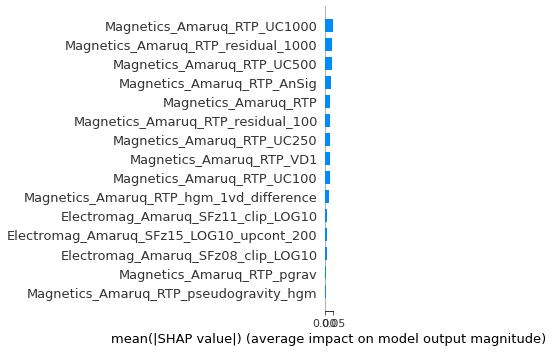

In [47]:
ozer_featureimportance_2.plot_shap_values(
    CatBoost_bestpipeline_fitted_model['clf'], 
    X_test,
    PathToSave=reporting_folder,
    set_size=(5,5)
)


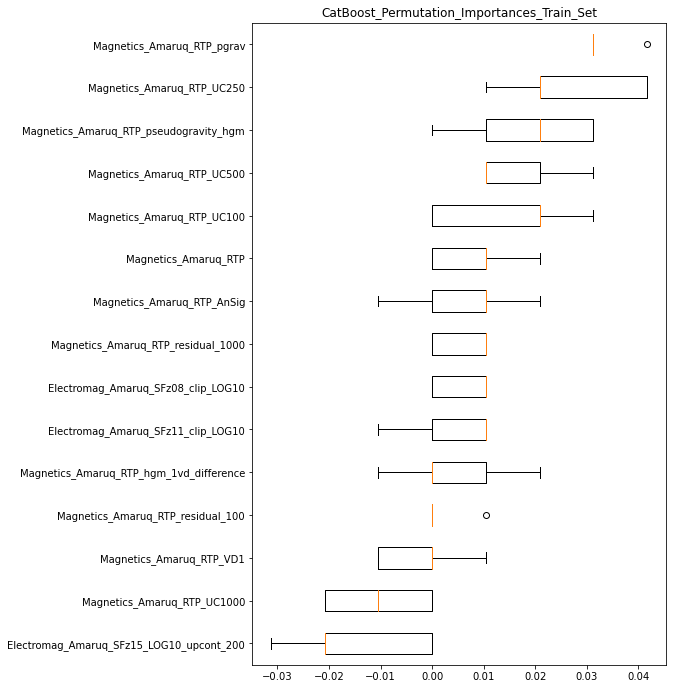

(<Figure size 1080x792 with 1 Axes>,
 <AxesSubplot:title={'center':'CatBoost_Permutation_Importances_Train_Set'}>)

In [50]:
ozer_featureimportance_2.plot_permutation_importance(
    CatBoost_bestpipeline_fitted_model,
    X_train,
    y_train,
    PathToSave=reporting_folder, 
    title= 'CatBoost_Permutation_Importances_Train_Set'
)

In [49]:
reporting_folder

'TestFunctions/reporting/'

In [59]:
import ozer_featureimportance_4

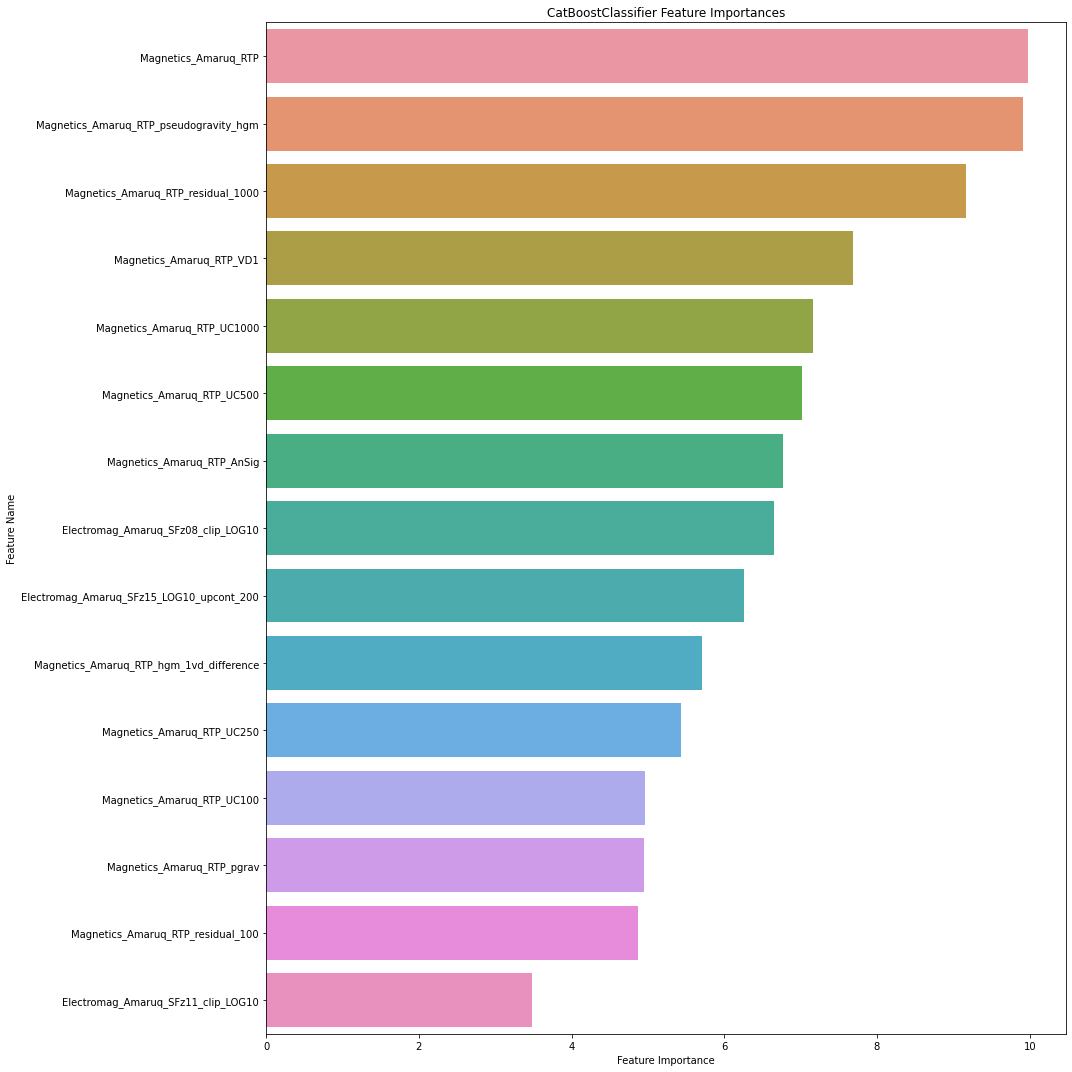

In [66]:
ozer_featureimportance_4.plot_feature_importance(CatBoost_bestpipeline_fitted_model['clf'], 
                          CatBoost_bestpipeline_fitted_model.feature_names_in_,
                          PathToSave=reporting_folder, 
                          title= 'CatBoost_Feature_Importances_Test.png',
                          set_size=(20,20))

SVM_bestpipeline_fitted_model


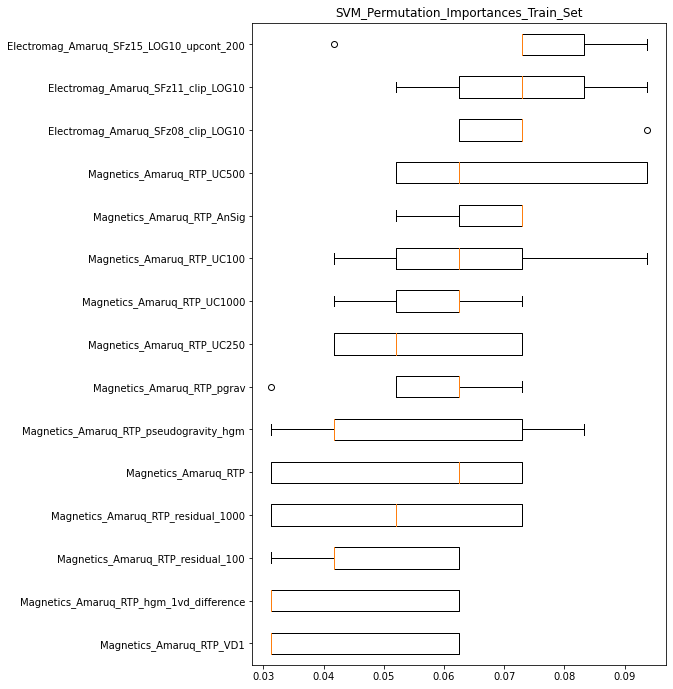

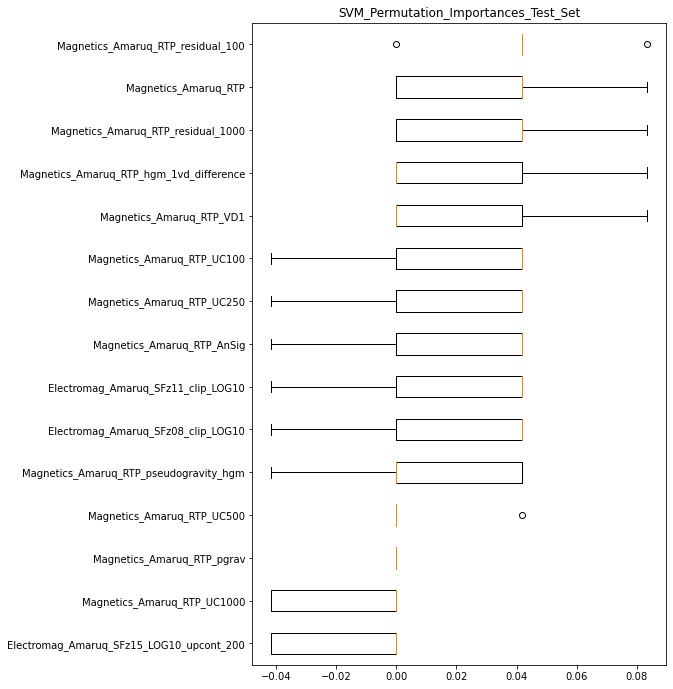

CatBoost_bestpipeline_fitted_model


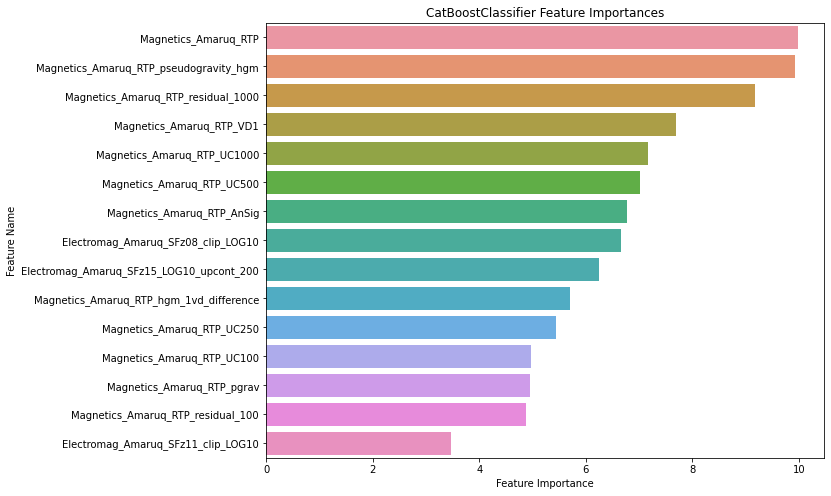

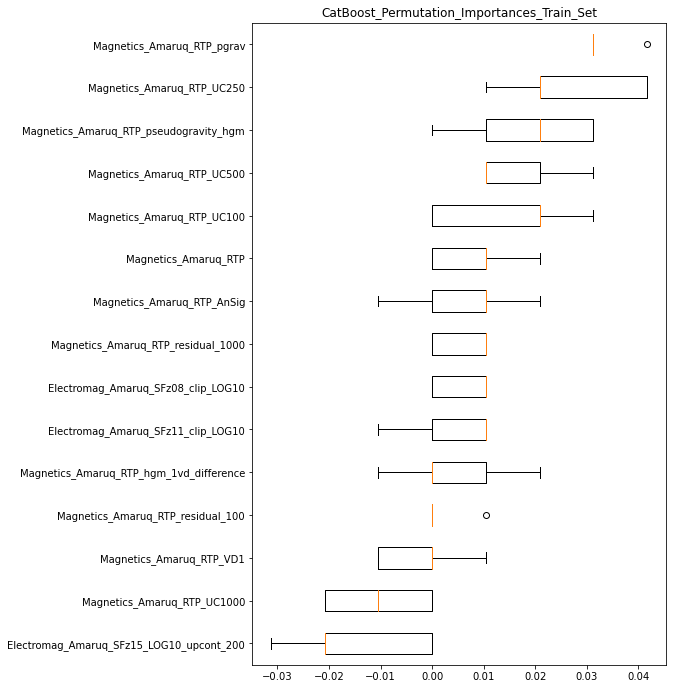

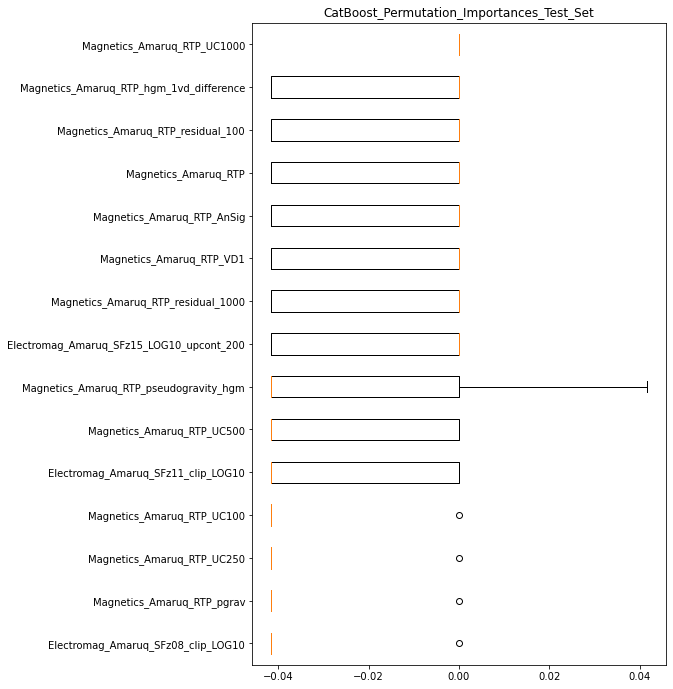

XGBoost_bestpipeline_fitted_model


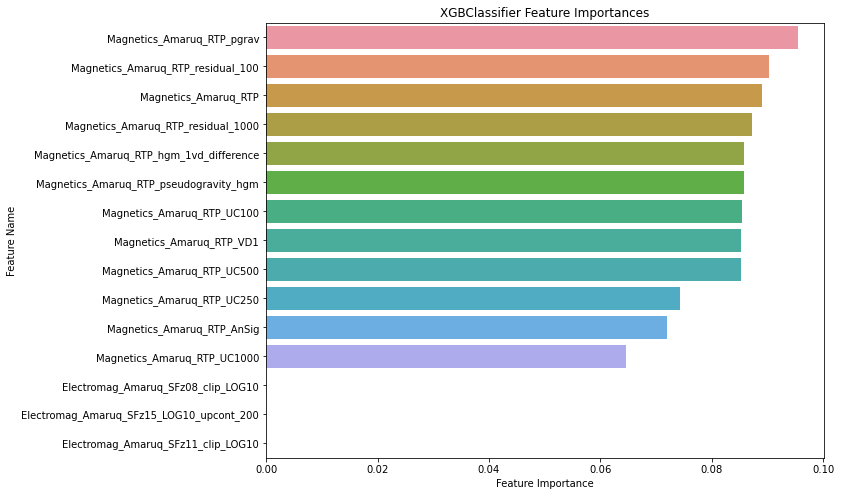

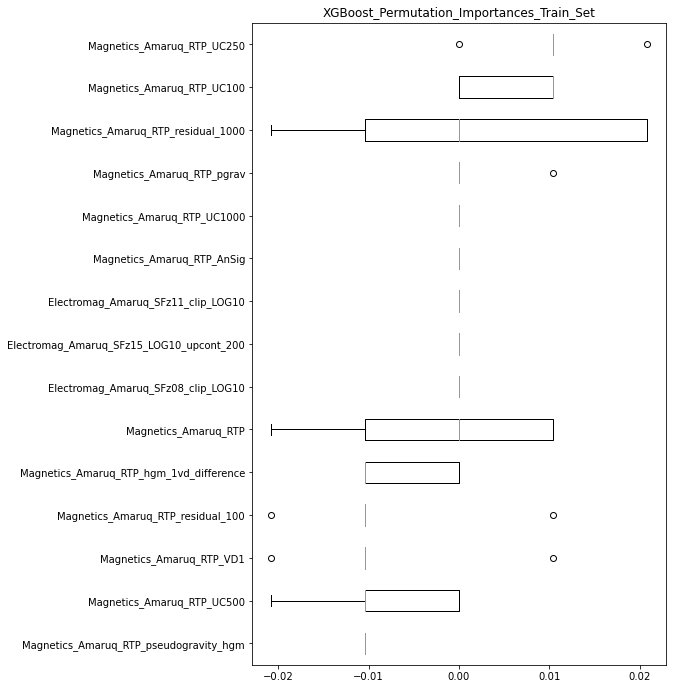

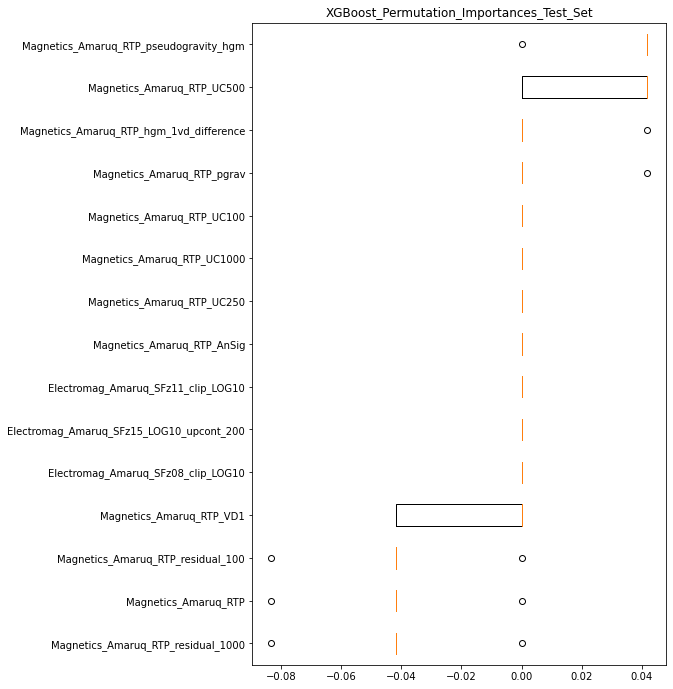

RandomForest_bestpipeline_fitted_model


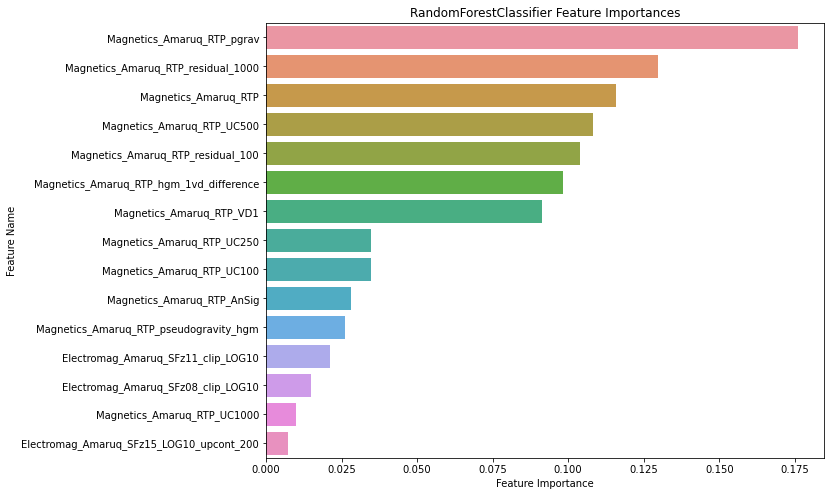

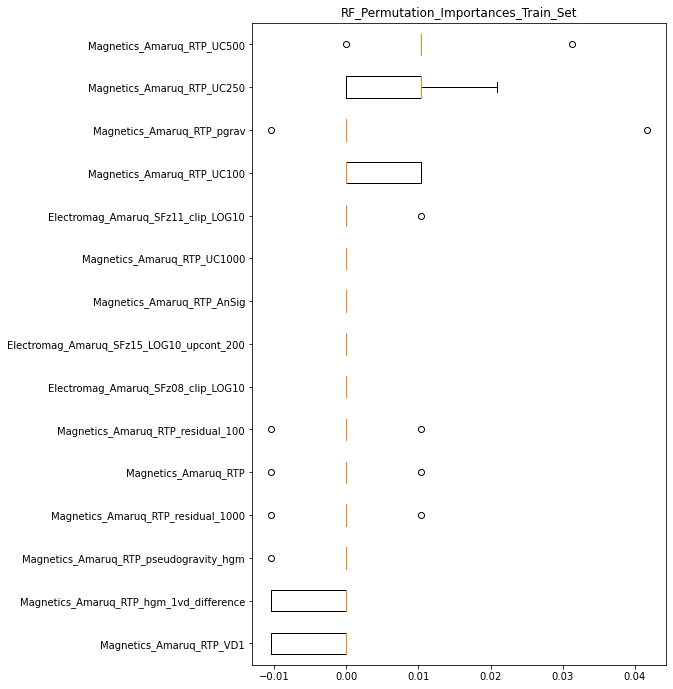

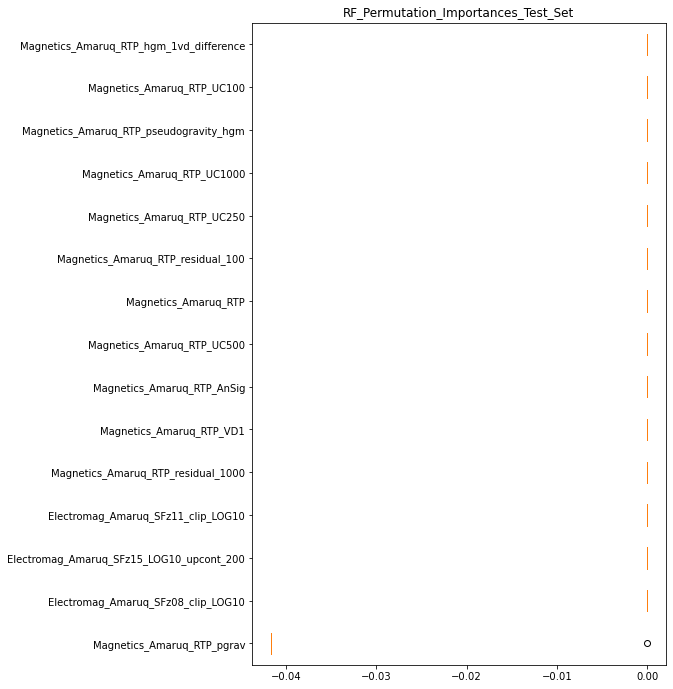

In [40]:
best_fitted_models = hyperparameterstuning.loadJobsFromFolder(output_folder+"/models/")

for model in best_fitted_models.keys():
    print(model)
    model_path = output_folder + 'models/' + f'{model}.joblib'
    
    # load models from disk
    if model == 'SVM_bestpipeline_fitted_model':
        SVM_bestpipeline_fitted_model = load(model_path)
        fe.plot_permutation_importance(SVM_bestpipeline_fitted_model, X_train, y_train, output=reporting_folder, 
                            title= 'SVM_Permutation_Importances_Train_Set')
        fe.plot_permutation_importance(SVM_bestpipeline_fitted_model, X_test, y_test, output=reporting_folder, 
                            title= 'SVM_Permutation_Importances_Test_Set')
    
    if model == 'CatBoost_bestpipeline_fitted_model':
        CatBoost_bestpipeline_fitted_model = load(model_path)
        fe.plot_feature_importance(CatBoost_bestpipeline_fitted_model['clf'], 
                          CatBoost_bestpipeline_fitted_model.feature_names_in_,
                          output=reporting_folder, 
                          title= 'CatBoost_Feature_Importances.png')
        fe.plot_permutation_importance(CatBoost_bestpipeline_fitted_model, X_train, y_train, output=reporting_folder, 
                            title= 'CatBoost_Permutation_Importances_Train_Set')
        fe.plot_permutation_importance(CatBoost_bestpipeline_fitted_model, X_test, y_test, output=reporting_folder, 
                            title= 'CatBoost_Permutation_Importances_Test_Set')
        
    if model == 'XGBoost_bestpipeline_fitted_model':
        XGBoost_bestpipeline_fitted_model = load(model_path)
        fe.plot_feature_importance(XGBoost_bestpipeline_fitted_model['clf'], 
                          XGBoost_bestpipeline_fitted_model.feature_names_in_,
                          output=reporting_folder, 
                          title= 'XGBoost_Feature_Importances.png')
        fe.plot_permutation_importance(XGBoost_bestpipeline_fitted_model, X_train, y_train, output=reporting_folder, 
                            title= 'XGBoost_Permutation_Importances_Train_Set')
        fe.plot_permutation_importance(XGBoost_bestpipeline_fitted_model, X_test, y_test, output=reporting_folder, 
                            title= 'XGBoost_Permutation_Importances_Test_Set')
        
    if model == 'LGBM_bestpipeline_fitted_model':
        LGBM_bestpipeline_fitted_model = load(model_path)
        fe.plot_feature_importance(LGBM_bestpipeline_fitted_model['clf'], 
                          LGBM_bestpipeline_fitted_model.feature_names_in_,
                          output=reporting_folder, 
                          title= 'LGBM_Feature_Importances.png')       
        fe.plot_permutation_importance(LGBM_bestpipeline_fitted_model, X_train, y_train, output=reporting_folder, 
                            title= 'LGBM_Permutation_Importances_Train_Set')
        fe.plot_permutation_importance(LGBM_bestpipeline_fitted_model, X_test, y_test, output=reporting_folder, 
                            title= 'LGBM_Permutation_Importances_Test_Set')
        
    if model == 'RandomForest_bestpipeline_fitted_model':
        RandomForest_bestpipeline_fitted_model = load(model_path)
        fe.plot_feature_importance(RandomForest_bestpipeline_fitted_model['clf'], 
                          RandomForest_bestpipeline_fitted_model.feature_names_in_,
                          output=reporting_folder, 
                          title= 'RF_Feature_Importances.png')        
        fe.plot_permutation_importance(RandomForest_bestpipeline_fitted_model, X_train, y_train, output=reporting_folder, 
                            title= 'RF_Permutation_Importances_Train_Set')
        fe.plot_permutation_importance(RandomForest_bestpipeline_fitted_model, X_test, y_test, output=reporting_folder, 
                            title= 'RF_Permutation_Importances_Test_Set')
        
        

In [78]:
import seaborn as sns

def plot_feature_importance_update(model, feature_names, **kwargs):
    """
    Create feature importance using sklearn's ensemble models model.feature_importances_ property.

    Parameters
    ----------
    model : class
        any class from sklearn ensemble or tree familly, see https://scikit-learn.org/stable/search.html?q=feature_importances_
    feature_names : list
        name of the variables

    Returns
    -------
    fig : Matplotlib.Figure
        Figure from matplotlib

    """
    # Create arrays from feature importance and feature names

    feature_importance = np.array(model.feature_importances_)

    feature_names = np.array(feature_names)

    # Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # Define size of bar plot
    fig, ax = plt.subplots()
            
    # Plot Searborn bar chart
    ax = sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    # Add chart labels
    model_name = str(type(model)).split(".")[-1][:-2]
    plt.title(model_name + ' Feature Importances')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')

    fig.set_size_inches(12, 12)
    fig.tight_layout()
    
    if "output" in kwargs and "title" in kwargs:
        fig.savefig(kwargs['output'] + kwargs['title'])

    return

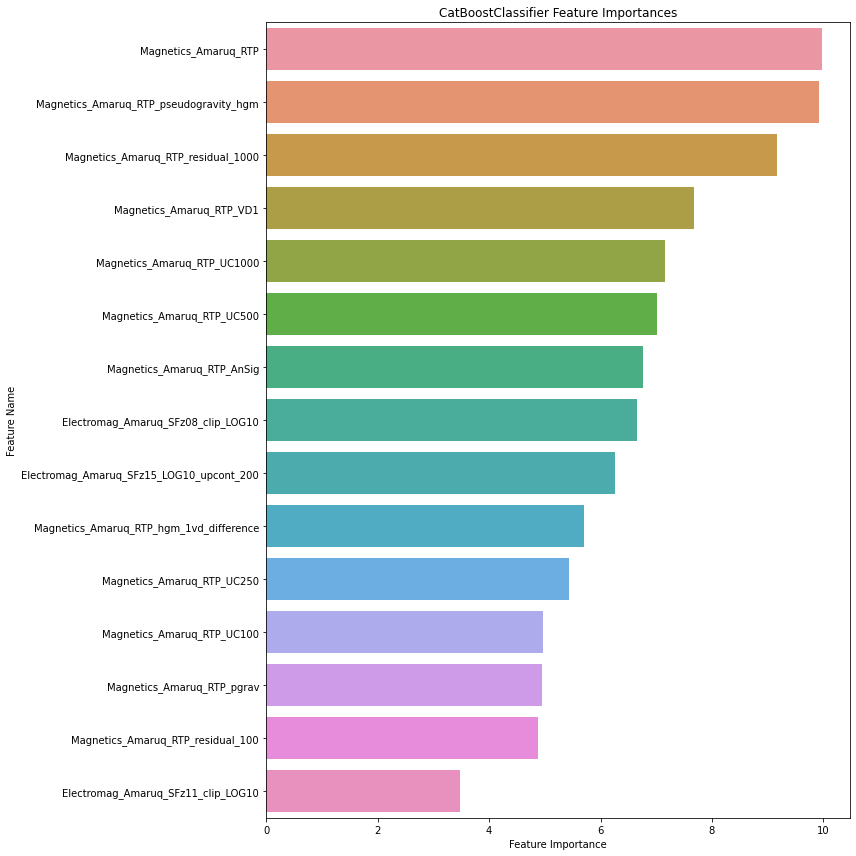

In [79]:
plot_feature_importance_update(CatBoost_bestpipeline_fitted_model['clf'], 
                          CatBoost_bestpipeline_fitted_model.feature_names_in_,
                          output=reporting_folder, 
                          title= 'CatBoost_Feature_Importances.png',
                          dpi=100)

In [82]:
import shap

In [159]:
def plot_shap_values(estimator, X_test, **kwargs):
    """
    Create a plot of shap values for a given pre-fitted estimator. SHAP VALUES DO NOT SUPPORT STACKING CLASSIFIERS

    Parameters
    ----------
    estimator : sklearn
    X_test : pandas.DataFrame
        The test portion of a dataset
    """
    # REFERENCES :
    # https://github.com/slundberg/shap/issues/406
    # PROBLEM #1 : Categorial values are plotted grey which is when shap values are NaN (see ref above)
    explainer = shap.TreeExplainer(estimator)

    # JM- The categories are already encoded in the CLF from the pipeline, so no need for categorical encoding
    # X_train_pro = pd.get_dummies(X_train)
    # shap_values = explainer.shap_values(X_train_pro)
    (n, d) = X_test.shape
    shap_values = explainer.shap_values(X_test)
    
    # I will take care of later. We can provide another plot!
    #shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, max_display = d, show=False)
    #fig = plt.gcf()
    #fig.set_size_inches(12, 12)
    #fig.tight_layout()
    #fig.show()
    
    shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, plot_type="bar", max_display = d, show=False)
    fig = plt.gcf()
    fig.set_size_inches(12, 12)
    fig.tight_layout()    
        
    if "output" in kwargs and "title" in kwargs:
        fig.savefig(kwargs['output'] + kwargs['title'], dpi=100)
        
    return

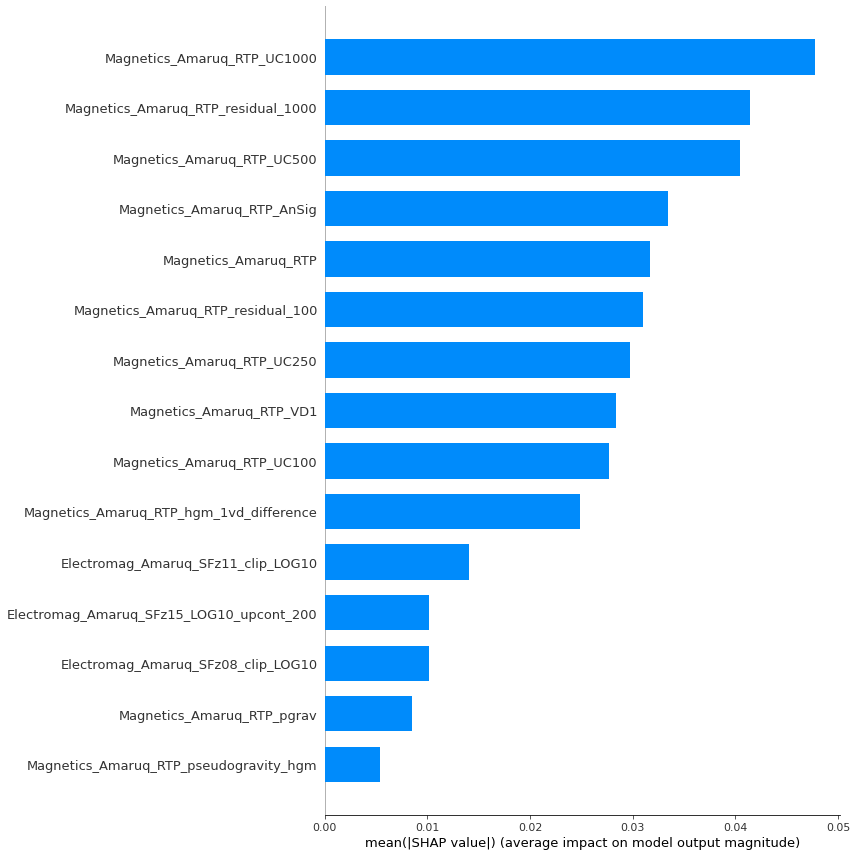

In [160]:
plot_shap_values(CatBoost_bestpipeline_fitted_model['clf'], X_test,
                          output=reporting_folder, 
                          title= 'CatBoost_SHAP_values.png')

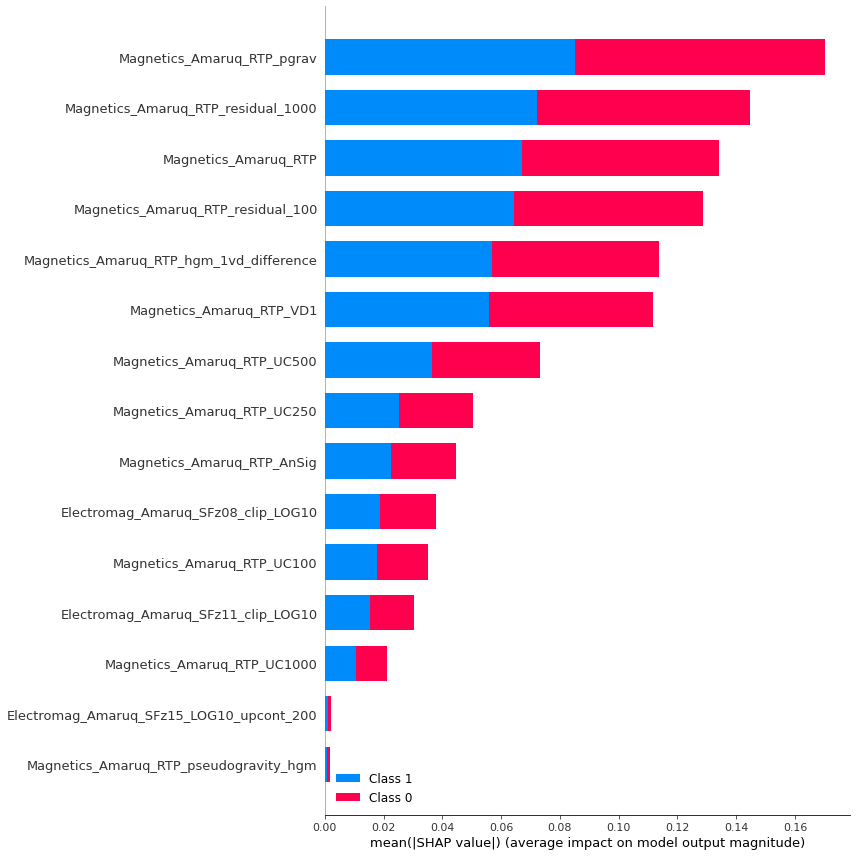

In [162]:
plot_shap_values(RandomForest_bestpipeline_fitted_model['clf'], X_test,
                          output=reporting_folder, 
                          title= 'RF_SHAP_values.png')

# SHAP Values

ERROR! Session/line number was not unique in database. History logging moved to new session 10


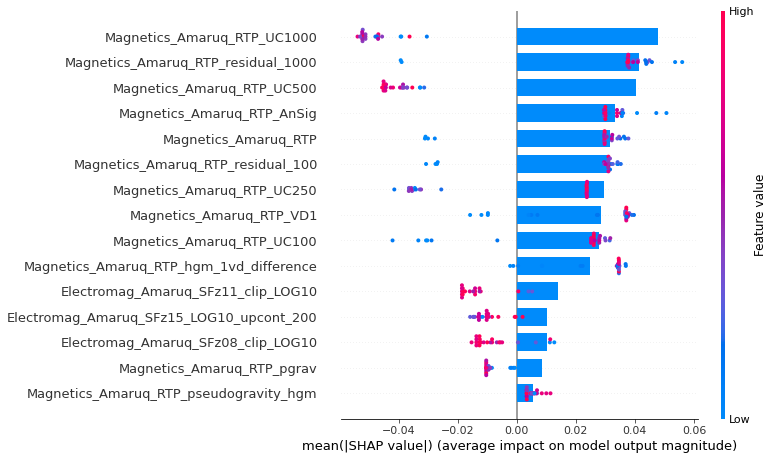

In [40]:
fe.plot_shap_values(CatBoost_bestpipeline_fitted_model['clf'], X_test,
                          output=reporting_folder, 
                          title= 'CatBoost_SHAP_values.png')

In [41]:
#fe.plot_shap_values(LGBM_bestpipeline_fitted_model['clf'], X_test,
#                          output=reporting_folder, 
#                          title= 'LGBM_SHAP_values.png')

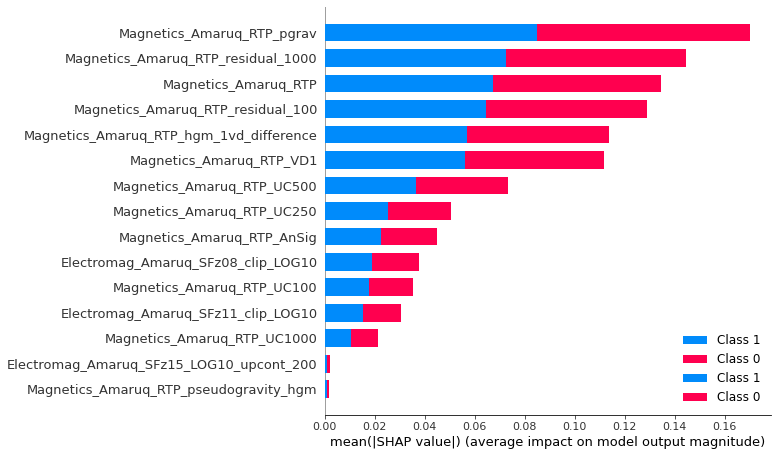

In [42]:
fe.plot_shap_values(RandomForest_bestpipeline_fitted_model['clf'], X_test,
                          output=reporting_folder, 
                          title= 'RF_SHAP_values.png')

# Stacking Classifier

In [43]:
jobs = hyperparameterstuning.loadJobsFromFolder(output_folder+"/pipelines/")
optuna_studies = hyperparameterstuning.loadJobsFromFolder(output_folder+"/studies/")

studies_dir = output_folder + '/studies'
pipeline_dir = output_folder + '/pipelines'


for e in glob.glob(studies_dir + '*.joblib'):
    mlflow.log_artifacts(e)

estimators = []
i = 0
for key in jobs:
    estimators.append((str(i),jobs[key]))
    i = i + 1
# saving the optimization trial results as a csv
studies = []
for i, j in optuna_studies.items():
    temp = j.trials_dataframe()
    temp.to_csv(output_folder + "/"+i+".csv")

In [44]:
# Build a Stacking classifier
pipeline = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
pipeline.fit(X_train, y_train)
model_joblib = output_folder + f'stacking-classifier_{target}.joblib'
dump(pipeline, model_joblib)

# Predictions on the test set
y_pred = pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred, average="macro")
prec = precision_score(y_test, y_pred, average="macro")
acc = accuracy_score(y_test, y_pred)

print("F1 Score is {}".format(f1))
print("Accuracy Score is {}".format(acc))
print("Prec Score is {}".format(prec))

[22:11:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:11:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:11:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:11:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [45]:
all_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1269239 entries, 17589 to 2318058
Data columns (total 15 columns):
 #   Column                                    Non-Null Count    Dtype  
---  ------                                    --------------    -----  
 0   Electromag_Amaruq_SFz08_clip_LOG10        1269239 non-null  float64
 1   Electromag_Amaruq_SFz15_LOG10_upcont_200  1269239 non-null  float64
 2   Electromag_Amaruq_SFz11_clip_LOG10        1269239 non-null  float64
 3   Magnetics_Amaruq_RTP_pgrav                1269239 non-null  float64
 4   Magnetics_Amaruq_RTP_residual_1000        1269239 non-null  float64
 5   Magnetics_Amaruq_RTP_VD1                  1269239 non-null  float64
 6   Magnetics_Amaruq_RTP_AnSig                1269239 non-null  float64
 7   Magnetics_Amaruq_RTP_UC500                1269239 non-null  float64
 8   Magnetics_Amaruq_RTP                      1269239 non-null  float64
 9   Magnetics_Amaruq_RTP_residual_100         1269239 non-null  float64
 10  Ma

In [ ]:
all_predictions = pipeline.predict(all_X)
all_predicted_prob = pipeline.predict_proba(all_X)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



[22:10:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [46]:
prob_class = [
    '0_probability',
    '1_probability'
    ]

In [ ]:
predictions = cube.subset(['coordinates'])
predictions['predictions'] = all_predictions.tolist()
predictions[prob_class] = all_predicted_prob
predictions['maxProb'] = np.max(all_predicted_prob, 1)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 11
Traceback (most recent call last):
  File "/root/miniconda3/envs/geods37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3251/1030029806.py", line 2, in <module>
    predictions['predictions'] = all_predictions.tolist()
NameError: name 'all_predictions' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/miniconda3/envs/geods37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2064, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/miniconda3/envs/geods37/lib/python3.7/site-packages/IPytho

In [ ]:
from scipy.stats import entropy
predictions['entropy'] = entropy(all_predicted_prob, axis = 1)/np.log(len(np.unique(y_train)))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/root/miniconda3/envs/geods37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3251/550669631.py", line 2, in <module>
    predictions['entropy'] = entropy(all_predicted_prob, axis = 1)/np.log(len(np.unique(y_train)))
NameError: name 'all_predicted_prob' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/miniconda3/envs/geods37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2064, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/miniconda3/envs/geods37/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    re

In [47]:
predictions

,x,y
17589,630437.5,7266437.5
17590,630462.5,7266437.5
17591,630487.5,7266437.5
19558,630387.5,7266412.5
19559,630412.5,7266412.5
...,...,...
2316089,589012.5,7237262.5
2316090,589037.5,7237262.5
2316091,589062.5,7237262.5
2318057,588937.5,7237237.5


In [ ]:
predictions[predictions.predictions == 1]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 13
Traceback (most recent call last):
  File "/root/miniconda3/envs/geods37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3251/4229445563.py", line 1, in <module>
    predictions[predictions.predictions == 1]
  File "/root/miniconda3/envs/geods37/lib/python3.7/site-packages/pandas/core/generic.py", line 5487, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'predictions'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/miniconda3/envs/geods37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2064, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

Du

In [ ]:
predictions['predictions'].value_counts()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/root/miniconda3/envs/geods37/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3361, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 76, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 108, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'predictions'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/root/miniconda3/envs/geods37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3251/1456774904.py", line 1, in <module>
    predictions['predictions'].val

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/root/miniconda3/envs/geods37/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3361, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 76, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 108, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'predictions'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/root/miniconda3/envs/geods37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3251/1456774904.py", line 1, in <module>
    predictions['predictions'].val

In [48]:
def replace_classes(actual_classes, correspondance_dict):
    original_classes = [correspondance_dict[code] for code in actual_classes]
    return original_classes

In [49]:
correspondance_dict = {0: "0", 
                       1: "1"}

actual_classes = y_test.unique().tolist()
actual_classes.sort()
classes = replace_classes(actual_classes, correspondance_dict)
classes

ERROR! Session/line number was not unique in database. History logging moved to new session 15


['0', '1']

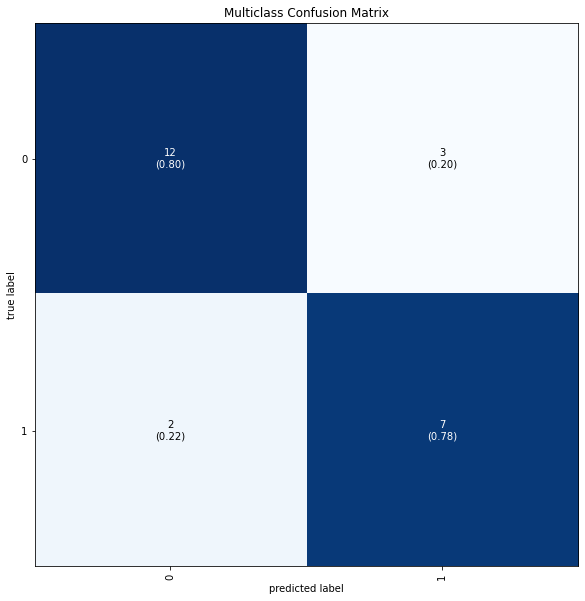

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Multiclass Confusion Matrix'}, xlabel='predicted label', ylabel='true label'>)

In [50]:
reporting.multiclass_confusion_matrix_plot(y_test, y_pred, actual_classes, reporting_folder)

(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:title={'center':'Confusion Matrix for Gold'}, xlabel='predicted label', ylabel='true label'>)

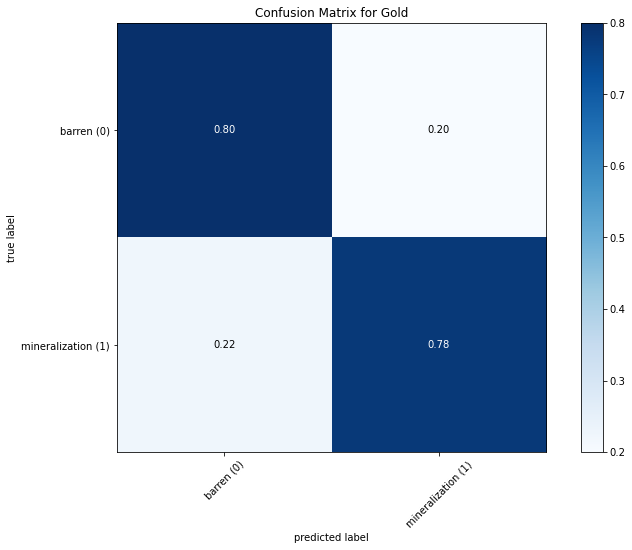

In [51]:
reporting.confusion_matrix_plot(y_test, y_pred, title="Gold", output=reporting_folder)

In [ ]:
fe.plot_permutation_importance(pipeline, X_train, y_train, output=reporting_folder, 
                            title= 'StackClassifier_Permutation_Importances_Train_Set')

In [ ]:
fe.plot_permutation_importance(pipeline, X_test, y_test, output=reporting_folder, 
                            title= 'StackClassifier_Permutation_Importances_Test_Set')

In [ ]:
fe.plot_stacked_feature_importance(X_train, y_train, output=reporting_folder,
                                   title="FeatureImportance_TrainSet.png")

In [ ]:
fe.plot_stacked_feature_importance(X_test, y_test, output=reporting_folder,
                                   title="FeatureImportance_TestSet.png")

In [ ]:
predictions.columns

In [ ]:
predictions_columns = ['predictions', '0_probability', '1_probability', 'maxProb', 'entropy']
utilities.csv_to_raster(predictions, os.path.join(predictions_folder), predictions_columns, None, 'x','y', crs)

In [ ]:
tifs = glob.glob(predictions_folder + '*.tif')

for t in tifs:
    filename,  extension, directory= utilities.Path_Info(t)
    utilities.geotiff_to_jpg(t, os.path.join(predictions_folder, filename + '.jpg'))

In [ ]:
ers_to_geotiff(input_ers, output_tif, dstCRS, x_resolution, y_resolution

In [15]:
input_ers = 'Warrawoona_alb.ers'
output_tif = 'Warrawoona_alb.tif'
dstCRS = crs
x_resolution = xRes 
y_resolution = yRes

utilities.ers_to_geotiff(input_ers, output_tif, dstCRS, x_resolution, y_resolution)

Translate process done. See result in Warrawoona_alb.tif
